**THIS CHAPTER IS CURRENTLY UNDER CONSTRUCTION!!!**

(information-theory)=
# Information theory

## KL divergence



```{prf:definition}
:label: KL-words-def

Let $P$ and $Q$ be two probability measures on a finite probability space $S$ with mass functions $p(s)$ and $q(s)$. Then the _KL divergence_ from $P$ to $Q$, denoted $D(P \parallel Q)$, is the mean logarithm of the relative magnitude of $P$ to $Q$. Precisely, it is given by

$$
D(P \parallel Q) = \sum_{s\in S} p(s) \log_2\left( \frac{p(s)}{q(s)} \right).
$$ (kl-eq)
```

Notice that the word "mean" in the definition refers to the mean with respect to $P$: The right-hand side of {eq}`kl-eq` is a weighted sum of the log relative magnitudes with weights drawn from the mass function $p(s)$. Therefore, the KL divergence is generally _not_ symmetric in the two distributions:

$$
D( P \parallel Q) \neq D(Q \parallel P).
$$

Problems are encountered in a strict interpretation of the formula {eq}`kl-eq` when one or the other (or both) of the mass functions are $0$. In these cases, it is conventional to define:

$$
p \log_2\left( \frac{p}{q} \right) = \begin{cases}
0 & : p =0, \ q=0, \\
0 & : p = 0, \ q\neq 0, \\
\infty & : p \neq 0, \ q=0.
\end{cases}
$$

It might be instructive to _see_ the raw parts and pieces that go into a computation of KL divergence. So, let's suppose that we have the two random variables

$$
X\sim \Bin(10, 0.5) \quad \text{and} \quad Y \sim \Bin(10, 0.9)
$$

with mass functions $p(x)$ and $q(y)$, respectively. To compute the two KL divergences

$$
D(P \parallel Q) \quad \text{and} \quad D(Q \parallel P),
$$

we compute the following:

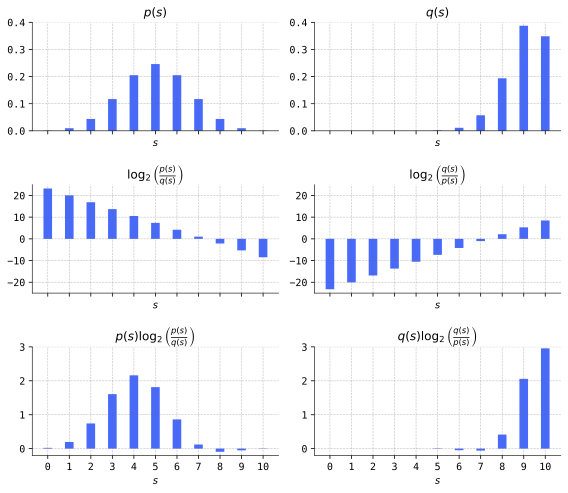

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib_inline.backend_inline
import warnings
plt.style.use('../aux-files/custom_style_light.mplstyle')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
blue = '#486AFB'
magenta = '#FD46FC'

grid = np.arange(0, 11)
p = sp.stats.binom(n=10, p=0.5).pmf(grid)
q = sp.stats.binom(n=10, p=0.9).pmf(grid)
titles = ['$p(s)$',
          '$q(s)$',
          '$\\log_2\\left(\\frac{p(s)}{q(s)}\\right)$',
          '$\\log_2\\left(\\frac{q(s)}{p(s)}\\right)$',
          '$p(s)\\log_2\\left(\\frac{p(s)}{q(s)}\\right)$',
          '$q(s)\\log_2\\left(\\frac{q(s)}{p(s)}\\right)$']
probs = [p,
         q,
         np.log2(p / q),
         np.log2(q / p),
         p * np.log2(p / q),
         q * np.log2(q / p)]
ylims = [(0, 0.4),
         (0, 0.4),
         (-25, 25),
         (-25, 25),
         (-0.2, 3),
         (-0.2, 3)]

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(8, 7), sharex=True)

for title, prob, ylim, axis in zip(titles, probs, ylims, axes.flatten()):
    axis.bar(grid, prob, width=0.4)
    axis.set_xticks(ticks=grid)
    axis.set_ylim(ylim)
    axis.set_title(title)
    axis.set_xlabel('$s$')

plt.tight_layout()

Notice that the two log relative magnitudes in the middle row are opposites of each other:

$$
\log_2\left(\frac{p(s)}{q(s)}\right) = -\log_2\left(\frac{q(s)}{p(s)}\right).
$$

The two KL divergences are computed by summing the (signed) heights of the bars in the last row:

$$
D(P \parallel Q ) \approx 7.370 \quad \text{and} \quad D(Q \parallel P) \approx 5.310.
$$